#Detection of Inland Water Bodies Using Machine Learning

##Project Objective
This project aims to detect and classify flooded versus non-flooded areas using Sentinel-2 satellite imagery and the Normalized Difference Water Index (NDWI). Focusing on two geographically and hydrologically distinct regions, the study evaluates changes in surface water extent and explores the combined utility of spectral indices and machine learning techniques for flood mapping.

##Study Areas
###Normandy Estuary, France
A coastal deltaic zone located in western Normandy, characterized by dense river networks, tidal inlets, and dynamic hydrology. This region is prone to seasonal flooding due to both river overflow and tidal influence, making it an ideal candidate for assessing flood detection techniques. It is represented by Sentinel-2 imagery from April 29, 2024 (Tile: T31UET).


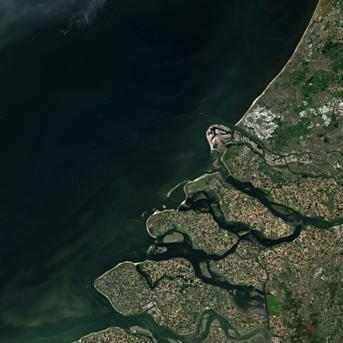
###Awbari Region, Libya
A hyper-arid inland area near the town of Awbari in the Libyan Sahara. This region experiences extremely low annual rainfall, sparse vegetation, and minimal surface water presence, making it suitable as a non-flooded baseline. It is represented by Sentinel-2 imagery from May 25, 2025 (Tile: T33RUN).


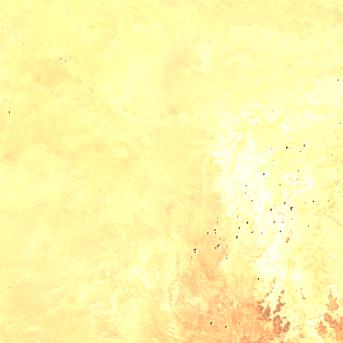

##Project Workflow
1.Acquire pre- and post-event Sentinel-2 imagery for target areas.

2.Generate NDWI masks using Green and NIR bands to detect surface water.

3.Classify surface types with K-means clustering; optionally validate with Random Forest.

4.Analyze spatial water patterns to assess flood impact.

5.Assess the environmental footprint of the analysis pipeline per AI4EO sustainability goals.



---

##  Notebook Requirements (Updated for Custom Study Areas)

This notebook uses `rasterio`, a Python library for reading and processing geospatial raster data such as **Sentinel-2 imagery**. It is used to extract bands required for computing the **Normalized Difference Water Index (NDWI)**.

You will need to mount your Google Drive to access your downloaded Sentinel-2 data. The code expects `.jp2` image files for **Band 03 (Green)** and **Band 08 (NIR)**. Be sure to update the file paths in the notebook to match the location of your `.SAFE` folders in Drive.

This version of the notebook is configured to analyze and compare **two specific geographic regions**:

* **Normandy, France** – A coastal delta region with dense river networks and dynamic tidal conditions. This flood-prone area serves as the **main flood analysis site**.
* **Awbari, Libya** – A hyper-arid inland desert area with minimal surface water. This region is used as a **non-flooded baseline** for contrast.

⚠


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 59.6 MB/s eta 0:00:00


#Dataset Setup and File Paths

The following code cell imports the required libraries and sets the file paths for the two Sentinel-2 datasets used in this project:

·Normandy, France (Wet/Flooded Condition) – Sentinel-2 imagery captured after a significant rainfall or tidal flooding event. This dataset represents the flood-affected area for NDWI-based analysis.

·Awbari, Libya (Dry/Control Condition) – Imagery from a hyper-arid inland desert region with minimal surface water. This serves as the non-flooded baseline for comparison.

The .jp2 file paths should point to the Sentinel-2 B03 (Green) and B08 (NIR) band images stored in your Google Drive. Make sure the paths are correctly linked from the IMG_DATA subfolder inside each .SAFE directory.

These paths will be used throughout the notebook for loading bands, calculating NDWI, and performing classification tasks.


In [3]:
# --- Import libraries
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# --- FDefine file paths for each region (verify paths before running)
# Awbari region (dry control)
green_Awbari = '/content/drive/MyDrive/final project/S2A_MSIL2A_20250525T094051_N0511_R036_T33RUN_20250525T120714.SAFE/GRANULE/L2A_T33RUN_A051828_20250525T094720/IMG_DATA/R10m/T33RUN_20250525T094051_B03_10m.jp2'
nir_Awbari   = '/content/drive/MyDrive/final project/S2A_MSIL2A_20250525T094051_N0511_R036_T33RUN_20250525T120714.SAFE/GRANULE/L2A_T33RUN_A051828_20250525T094720/IMG_DATA/R10m/T33RUN_20250525T094051_B08_10m.jp2'

# Normandy region (flooded)
green_Normandy = '/content/drive/MyDrive/final project/S2B_MSIL2A_20250429T104619_N0511_R051_T31UET_20250429T130440.SAFE/GRANULE/L2A_T31UET_A042548_20250429T104621/IMG_DATA/R10m/T31UET_20250429T104619_B03_10m.jp2'
nir_Normandy = '/content/drive/MyDrive/final project/S2B_MSIL2A_20250429T104619_N0511_R051_T31UET_20250429T130440.SAFE/GRANULE/L2A_T31UET_A042548_20250429T104621/IMG_DATA/R10m/T31UET_20250429T104619_B08_10m.jp2'




# Creating a Benchmark: Normalized Difference Water Index (NDWI)


The **Normalized Difference Water Index (NDWI)** is used to detect surface water using Sentinel-2 imagery. It highlights water by comparing reflected green light (**Band 03**) with absorbed near-infrared radiation (**Band 08**):

$$
\text{NDWI} = \frac{\text{Green} - \text{NIR}}{\text{Green} + \text{NIR}}
$$

In this project, NDWI is applied to two regions:

* **Normandy Estuary, France** (flooded)
* **Awbari Region, Libya** (dry)

To reduce memory usage, imagery is optionally downsampled before computing NDWI. Binary water masks are then created using a threshold of **0**:

* **NDWI > 0** → Water or flooded area (`1`)
* **NDWI ≤ 0** → Non-water (e.g., land, vegetation) (`0`)

These masks serve as a baseline to compare against machine learning results (e.g., K-means clustering) for flood impact analysis.

---




In [4]:
# --- Load and downsample both datasets (Khulna and Mandalay) ---

def load_band(path):
    with rasterio.open(path) as src:
        return src.read(1).astype('float32')

# Load original bands for both regions
green1 = load_band(green_Normandy)
nir1   = load_band(nir_Normandy)

green2 = load_band(green_Awbari)
nir2   = load_band(nir_Awbari)

# Optional: downsample to reduce memory usage
def downsample_array(arr, step=5):
    return arr[::step, ::step]

# Downsample step (adjust if needed)

step = 5  # You can increase this if RAM is still tight (e.g., step = 10)

# Apply downsampling
green1 = downsample_array(green1, step)
nir1   = downsample_array(nir1, step)
green2 = downsample_array(green2, step)
nir2   = downsample_array(nir2, step)

# Load profile metadata from one image (used later if exporting GeoTIFFs)
with rasterio.open(green_Normandy) as src:
    profile = src.profile



In [5]:
# === Compute NDWI for both regions ===
ndwi1 = (green1 - nir1) / (green1 + nir1 + 1e-10)
ndwi2 = (green2 - nir2) / (green2 + nir2 + 1e-10)

# === Apply NDWI threshold to generate binary masks ===
threshold = 0.0
ndwi_mask1 = (ndwi1 > threshold).astype('uint8')
ndwi_mask2 = (ndwi2 > threshold).astype('uint8')


ValueError: 'Greay' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Grays_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'berlin', 'berlin_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_grey_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gist_yerg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'grey_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'managua', 'managua_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'vanimo', 'vanimo_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

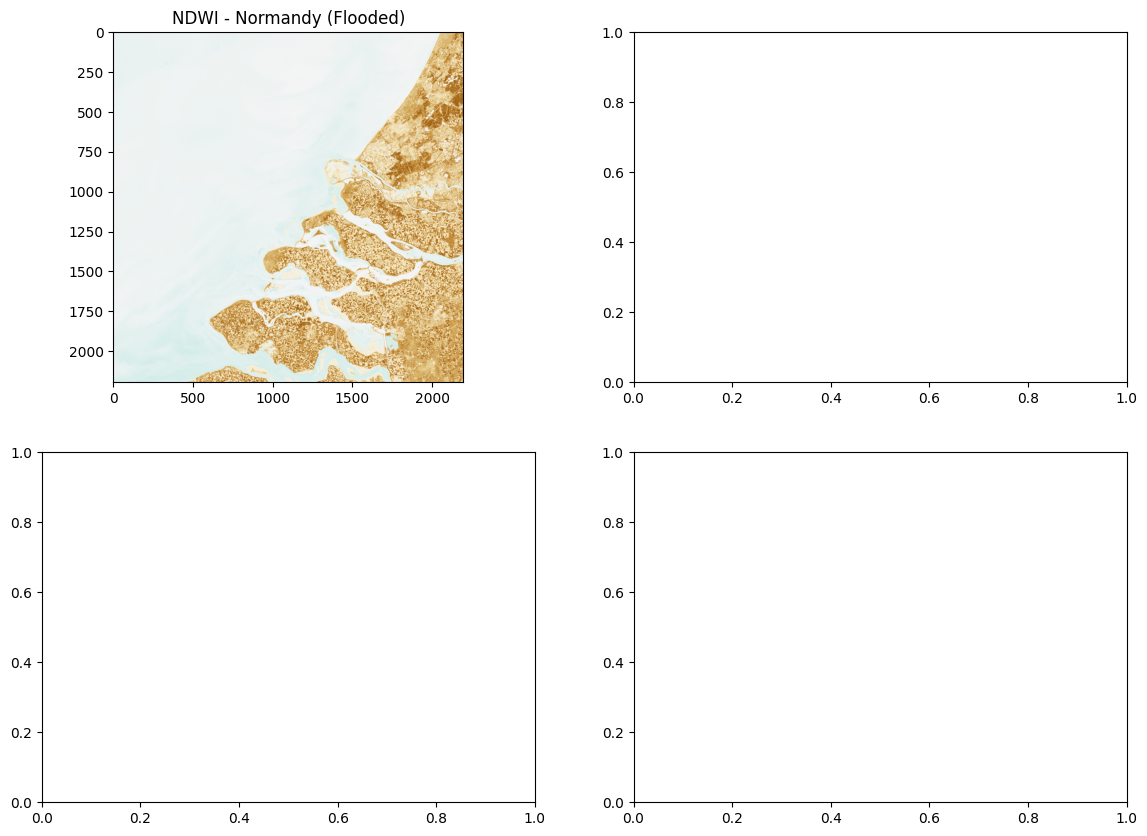

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].imshow(ndwi1, cmap='BrBG')
axs[0, 0].set_title('NDWI - Normandy (Flooded)')
axs[0, 1].imshow(ndwi_mask1, cmap='Greay')
axs[0, 1].set_title('NDWI Water Mask - Normandy')

axs[1, 0].imshow(ndwi2, cmap='BrBG')
axs[1, 0].set_title('NDWI - Awbari (Dry)')
axs[1, 1].imshow(ndwi_mask2, cmap='Greay')
axs[1, 1].set_title('NDWI Water Mask - Awbari')

plt.tight_layout()
plt.show()



##K-means Clustering Algorithm

K-means clustering is a widely used unsupervised machine learning method that groups pixels based on spectral similarity. It is especially useful when the data’s structure is unknown or when labeled training data is unavailable.

In this project, K-means clustering is applied to Sentinel-2 imagery from two contrasting environments:

Normandy, France – A flood-prone coastal region imaged after significant rainfall and tidal activity
Awbari, Libya – A hyper-arid inland desert region used as the non-flooded baseline
By clustering pixel values from selected band combinations (e.g., Green & NIR), the goal is to identify and classify surface water features and compare the extent of water coverage between wet and dry regions.

##Awbari Region

For the Awbari Region, which serves as the dry-environment baseline, we test three K-means clustering setups to evaluate water classification in a low-precipitation, high-reflectance desert context:

NDWI-based clustering: using bands 03 (Green) and 08 (NIR) – the traditional approach for water body detection
SWI-based clustering: using bands 05 (Vegetation Red Edge) and 11 (SWIR) – based on Jiang et al. (2020), this improves water extraction in complex or mixed landscapes
MNDWI-based clustering: using bands 03 (Green) and 11 (SWIR) – enhances detection of open water while minimizing confusion with urban or vegetated areas
By applying K-means to each band combination, we assess the effectiveness of these indices in distinguishing land and water in extremely dry settings.

###  Band Combination: NDWI (03 + 08)

In this method, we apply K-means on Sentinel-2 bands B03 (green) and B08 (NIR)to see if the unsupervised clustering approach captures flooded vs. non-flooded regions similarly to NDWI-based detection.


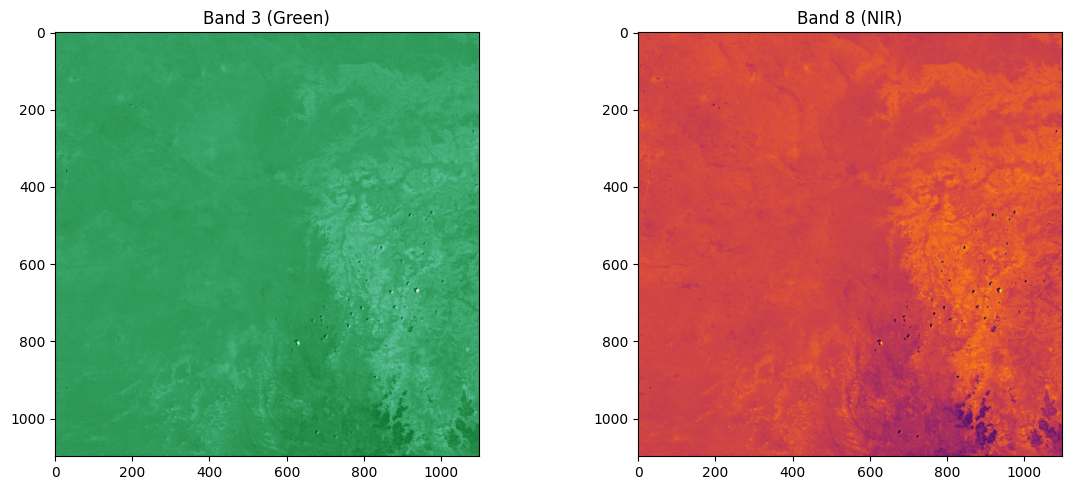

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# === Define file paths for Sentinel-2 Band 03 (Green) and Band 08 (NIR) ===
green_path = '/content/drive/MyDrive/final project/S2A_MSIL2A_20250525T094051_N0511_R036_T33RUN_20250525T120714.SAFE/GRANULE/L2A_T33RUN_A051828_20250525T094720/IMG_DATA/R10m/T33RUN_20250525T094051_B03_10m.jp2'
nir_path   = '/content/drive/MyDrive/final project/S2A_MSIL2A_20250525T094051_N0511_R036_T33RUN_20250525T120714.SAFE/GRANULE/L2A_T33RUN_A051828_20250525T094720/IMG_DATA/R10m/T33RUN_20250525T094051_B08_10m.jp2'

# === Downsampling function ===
def downsample(arr, step=10):
    return arr[::step, ::step]

# === Load and downsample bands ===
with rasterio.open(green_path) as src:
    band_green = downsample(src.read(1).astype('float32'))

with rasterio.open(nir_path) as src:
    band_nir = downsample(src.read(1).astype('float32'))

# === Stack bands into 3D array ===

band_stack = np.dstack([band_green, band_nir])


# === Plot bands side-by-side ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.imshow(band_stack[:, :, 0], cmap='BuGn_r')  # Green band
ax1.set_title('Band 3 (Green)')

ax2.imshow(band_stack[:, :, 1], cmap='inferno')  # NIR band
ax2.set_title('Band 8 (NIR)')

plt.tight_layout()
plt.show()



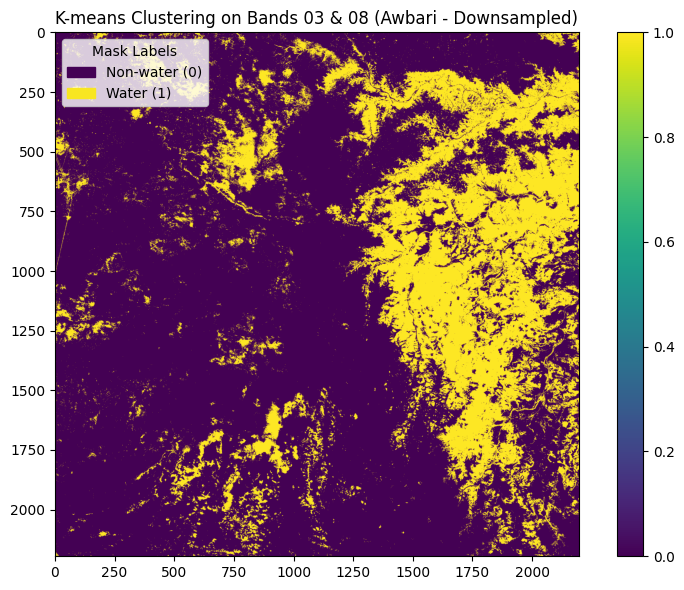

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.cluster import KMeans

# === Helper: Load and downsample a single band ===
def load_band(path, step=5):
    with rasterio.open(path) as src:
        band = src.read(1).astype('float32')
        return band[::step, ::step]

# === Define file paths for Awbari region (dry season) ===
green_path = '/content/drive/MyDrive/final project/S2A_MSIL2A_20250525T094051_N0511_R036_T33RUN_20250525T120714.SAFE/GRANULE/L2A_T33RUN_A051828_20250525T094720/IMG_DATA/R10m/T33RUN_20250525T094051_B03_10m.jp2'
nir_path   = '/content/drive/MyDrive/final project/S2A_MSIL2A_20250525T094051_N0511_R036_T33RUN_20250525T120714.SAFE/GRANULE/L2A_T33RUN_A051828_20250525T094720/IMG_DATA/R10m/T33RUN_20250525T094051_B08_10m.jp2'

# === Load bands and apply downsampling ===
green = load_band(green_path, step=5)
nir   = load_band(nir_path, step=5)

# === Stack bands and extract valid data points ===
stack = np.dstack([green, nir])
valid_pixels = np.all(stack > 0, axis=2)
X = stack[valid_pixels].reshape(-1, 2)

# === Apply K-means clustering ===
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X)

# === Map clustering results to image ===
mask = np.full(stack.shape[:2], -1, dtype=int)
mask[valid_pixels] = labels

# === Visualization ===
plt.figure(figsize=(8, 6))
legend_handles = [
    Rectangle((0, 0), 1, 1, color=plt.cm.viridis(0.0)),
    Rectangle((0, 0), 1, 1, color=plt.cm.viridis(0.99)),
]
plt.imshow(mask, cmap='viridis')
plt.title('K-means Clustering on Bands 03 & 08 (Awbari - Downsampled)')
plt.colorbar()
plt.legend(legend_handles, ['Non-water (0)', 'Water (1)'], loc='upper left', title='Mask Labels')
plt.tight_layout()
plt.show()


##Band Combination: SWI (05 + 11)
In this configuration, Sentinel-2 bands B05 (which captures vegetation edge reflectance) and B11 (shortwave infrared) are used as input for K-means clustering. This pairing is based on the SWI methodology introduced by Jiang et al., and is particularly effective at isolating water bodies in areas with complex surface conditions, such as mixed vegetation, soil, and built-up land.

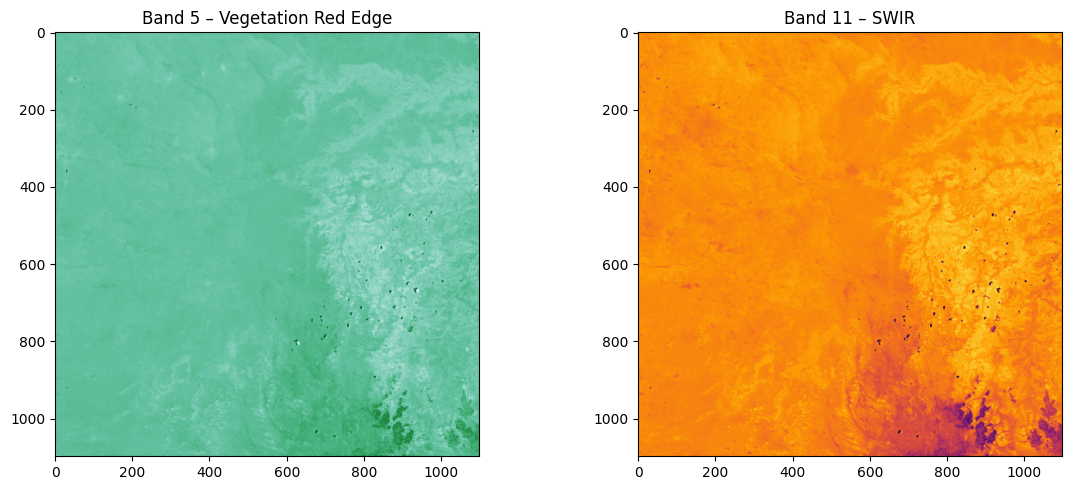

In [13]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# === File paths for B05 (Red Edge) and B11 (SWIR) ===
red_edge_path = '/content/drive/MyDrive/final project/S2A_MSIL2A_20250525T094051_N0511_R036_T33RUN_20250525T120714.SAFE/GRANULE/L2A_T33RUN_A051828_20250525T094720/IMG_DATA/R20m/T33RUN_20250525T094051_B05_20m.jp2'
swir_path     = '/content/drive/MyDrive/final project/S2A_MSIL2A_20250525T094051_N0511_R036_T33RUN_20250525T120714.SAFE/GRANULE/L2A_T33RUN_A051828_20250525T094720/IMG_DATA/R20m/T33RUN_20250525T094051_B11_20m.jp2'

# === Helper: Downsample array to reduce size ===
def downsample_array(array, factor=5):
    return array[::factor, ::factor]

# === Load and process bands ===
with rasterio.open(red_edge_path) as src:
    red_edge = downsample_array(src.read(1).astype('float32'))

with rasterio.open(swir_path) as src:
    swir = downsample_array(src.read(1).astype('float32'))

# === Stack the two bands into one array ===
stacked_bands = np.dstack([red_edge, swir])

# === Plot both bands side-by-side ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.imshow(stacked_bands[:, :, 0], cmap='BuGn_r')
ax1.set_title('Band 5 – Vegetation Red Edge')

ax2.imshow(stacked_bands[:, :, 1], cmap='inferno')
ax2.set_title('Band 11 – SWIR')

plt.tight_layout()
plt.show()


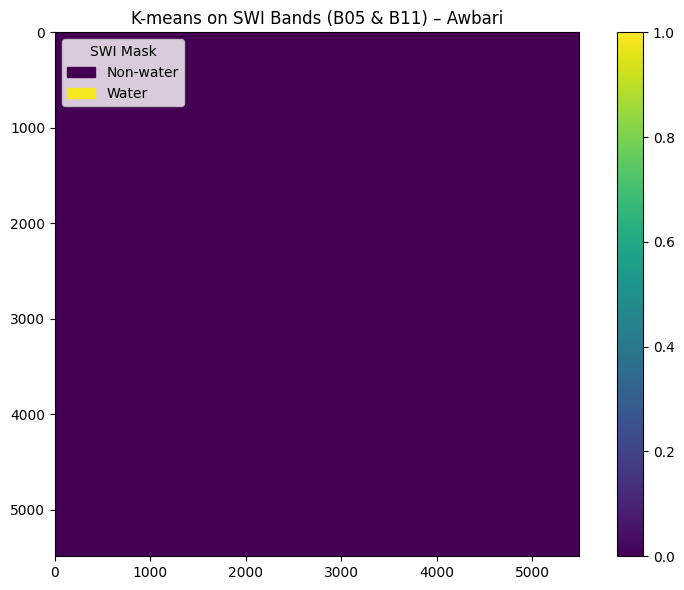

In [ ]:
import rasterio
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# === File paths for SWI bands (B05 and B11) ===
path_b05 = '/content/drive/MyDrive/final project/S2A_MSIL2A_20250525T094051_N0511_R036_T33RUN_20250525T120714.SAFE/GRANULE/L2A_T33RUN_A051828_20250525T094720/IMG_DATA/R20m/T33RUN_20250525T094051_B05_20m.jp2'
path_b11 = '/content/drive/MyDrive/final project/S2A_MSIL2A_20250525T094051_N0511_R036_T33RUN_20250525T120714.SAFE/GRANULE/L2A_T33RUN_A051828_20250525T094720/IMG_DATA/R20m/T33RUN_20250525T094051_B11_20m.jp2'

# === Load both bands and stack ===
swi_bands = []
for band_path in [path_b05, path_b11]:
    with rasterio.open(band_path) as src:
        swi_bands.append(src.read(1).astype('float32'))

swi_stack = np.dstack(swi_bands)
valid_pixels = np.all(swi_stack > 0, axis=2)
X_swi = swi_stack[valid_pixels].reshape(-1, 2)

# === K-means Clustering ===
kmeans_swi = KMeans(n_clusters=3, random_state=42)
kmeans_swi.fit(X_swi)
label_map = np.full(swi_stack.shape[:2], -1, dtype=int)
label_map[valid_pixels] = kmeans_swi.labels_

# === Create binary mask: assume cluster 0 is water ===
swi_mask = np.where(label_map >= 1, 0, 1)

# === Plotting ===
legend_patches = [
    Rectangle((0, 0), 1, 1, color=plt.cm.viridis(0)),
    Rectangle((0, 0), 1, 1, color=plt.cm.viridis(0.99))
]

plt.figure(figsize=(8, 6))
plt.imshow(swi_mask, cmap='viridis')
plt.title('K-means on SWI Bands (B05 & B11) – Awbari')
plt.colorbar()
plt.legend(legend_patches, ['Non-water', 'Water'], loc='upper left', title='SWI Mask')
plt.tight_layout()
plt.show()


·The selected area may not contain visible water bodies
The portion of the Awbari region you analyzed might correspond to a dry season, or the Sentinel-2 image was captured at a time when no flooding occurred. As a result, there may genuinely be no significant water presence in the scene.

·This comparison clearly shows that using Band 03 and Band 08 provides better spectral contrast between water and non-water surfaces, making it a more suitable input combination for unsupervised water mapping using K-means clustering.

##Band Combination: MNDWI (Bands 03 + 11)
This configuration uses K-means clustering on Sentinel-2 bands B03 (green) and B11 (shortwave infrared), following the Modified Normalized Difference Water Index (MNDWI) approach. It is especially effective in detecting water in environments where built-up infrastructure or vegetation may obscure surface water signals.

By reducing interference from urban and vegetated surfaces, this method enhances the visibility of open water, making it suitable for application in both flood-prone and arid areas.

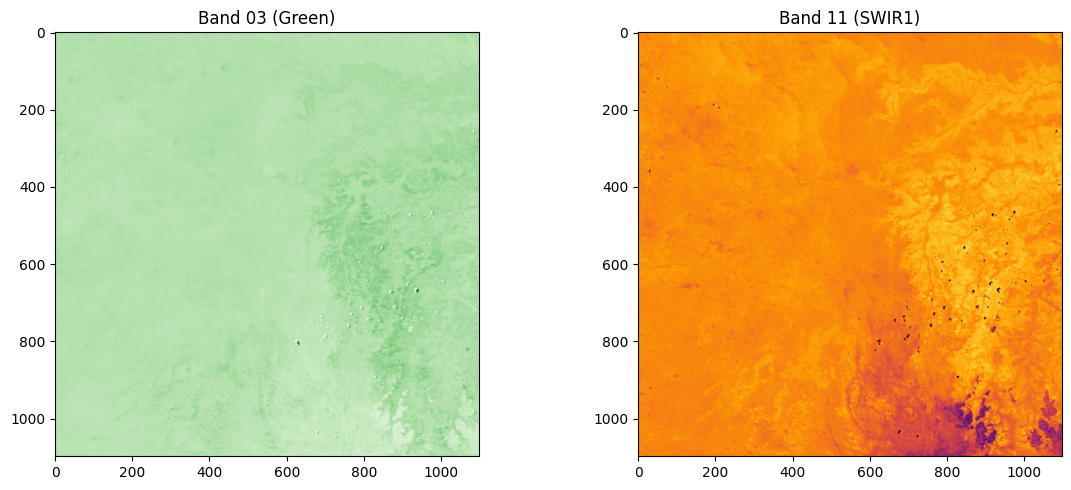

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# === Define file paths for Green (B03) and SWIR1 (B11) ===
path_b03 = '/content/drive/MyDrive/final project/S2A_MSIL2A_20250525T094051_N0511_R036_T33RUN_20250525T120714.SAFE/GRANULE/L2A_T33RUN_A051828_20250525T094720/IMG_DATA/R20m/T33RUN_20250525T094051_B03_20m.jp2'
path_b11 = '/content/drive/MyDrive/final project/S2A_MSIL2A_20250525T094051_N0511_R036_T33RUN_20250525T120714.SAFE/GRANULE/L2A_T33RUN_A051828_20250525T094720/IMG_DATA/R20m/T33RUN_20250525T094051_B11_20m.jp2'

# === Downsampling helper ===
def downsample_band(array, step=5):
    return array[::step, ::step]

# === Load and downsample bands ===
with rasterio.open(path_b03) as src:
    green_band = downsample_band(src.read(1).astype('float32'))

with rasterio.open(path_b11) as src:
    swir_band = downsample_band(src.read(1).astype('float32'))

# === Stack bands along depth ===
band_stack = np.dstack([green_band, swir_band])

# === Plot the bands side by side ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.imshow(band_stack[:, :, 0], cmap='Greens')
ax1.set_title('Band 03 (Green)')

ax2.imshow(band_stack[:, :, 1], cmap='inferno')
ax2.set_title('Band 11 (SWIR1)')

plt.tight_layout()
plt.show()


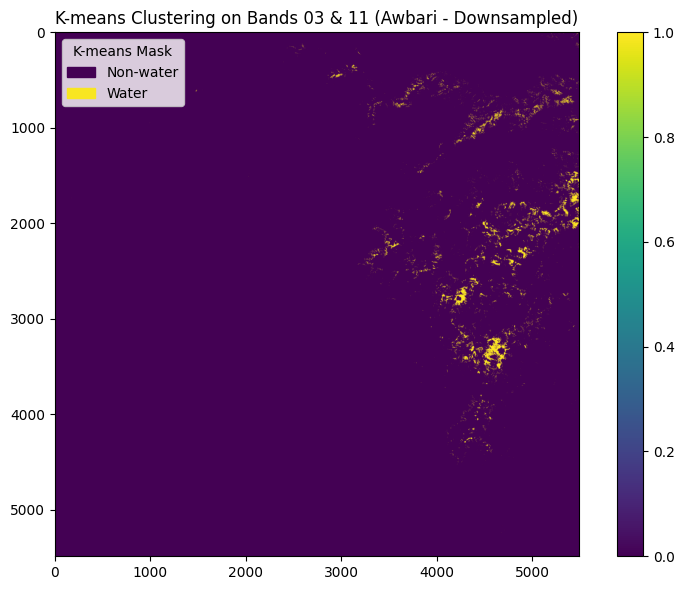

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.cluster import KMeans

# === File paths for Band 03 (Green) and Band 11 (SWIR1) ===
path_b03 = '/content/drive/MyDrive/final project/S2A_MSIL2A_20250525T094051_N0511_R036_T33RUN_20250525T120714.SAFE/GRANULE/L2A_T33RUN_A051828_20250525T094720/IMG_DATA/R20m/T33RUN_20250525T094051_B03_20m.jp2'
path_b11 = '/content/drive/MyDrive/final project/S2A_MSIL2A_20250525T094051_N0511_R036_T33RUN_20250525T120714.SAFE/GRANULE/L2A_T33RUN_A051828_20250525T094720/IMG_DATA/R20m/T33RUN_20250525T094051_B11_20m.jp2'

# === Load and stack bands ===
swi_bands = []
for path in [path_b03, path_b11]:
    with rasterio.open(path) as src:
        swi_bands.append(src.read(1).astype('float32'))

swi_stack = np.dstack(swi_bands)
valid_pixels = np.all(swi_stack > 0, axis=2)
X_swi = swi_stack[valid_pixels].reshape(-1, 2)

# === Apply K-means clustering ===
kmeans_swi = KMeans(n_clusters=3, random_state=42)
kmeans_swi.fit(X_swi)
label_map = np.full(swi_stack.shape[:2], -1, dtype=int)
label_map[valid_pixels] = kmeans_swi.labels_

# === Generate binary water mask (visually assumed: cluster 0 = water) ===
swi_mask = np.where(label_map >= 1, 0, 1)

# === Visualization ===
legend_patches = [
    Rectangle((0, 0), 1, 1, color=plt.cm.viridis(0.0)),
    Rectangle((0, 0), 1, 1, color=plt.cm.viridis(0.99))
]
legend_labels = ['Non-water', 'Water']

plt.figure(figsize=(8, 6))
plt.imshow(swi_mask, cmap='viridis')
plt.title('K-means Clustering on Bands 03 & 11 (Awbari - Downsampled)')
plt.colorbar()
plt.legend(legend_patches, legend_labels, loc='upper left', title='K-means Mask')
plt.tight_layout()
plt.show()


##Water Detection Comparison – Awbari Region (Dry Season)

This section compares multiple water detection methods applied to Sentinel-2 imagery over the Awbari Region, Libya, which represents a non-flooded, arid baseline.

We assess the effectiveness of unsupervised K-means clustering across several spectral band combinations, alongside the traditional Normalized Difference Water Index (NDWI). The comparison also includes the Modified NDWI (MNDWI), which is designed to improve water detection in built-up or vegetated landscapes.

The tested methods include:

NDWI mask using bands B03 & B08
K-means clustering applied to:
NDWI bands (B03 & B08)
SWI bands (B05 & B11)
MNDWI bands (B03 & B11)

##NDWI-Based vs. K-means Water Mask Comparison

This section presents a visual comparison between the traditional NDWI-derived water mask and the output from K-means clustering, both using the same Sentinel-2 bands (B03 and B08).

The goal is to evaluate whether unsupervised learning can effectively replicate water body patterns identified by NDWI, particularly in differentiating between flooded and non-flooded areas. The flood-prone site is located in Normandy, France, while the dry baseline is from Awbari, Libya.

Below is a side-by-side comparison of the two methods.

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


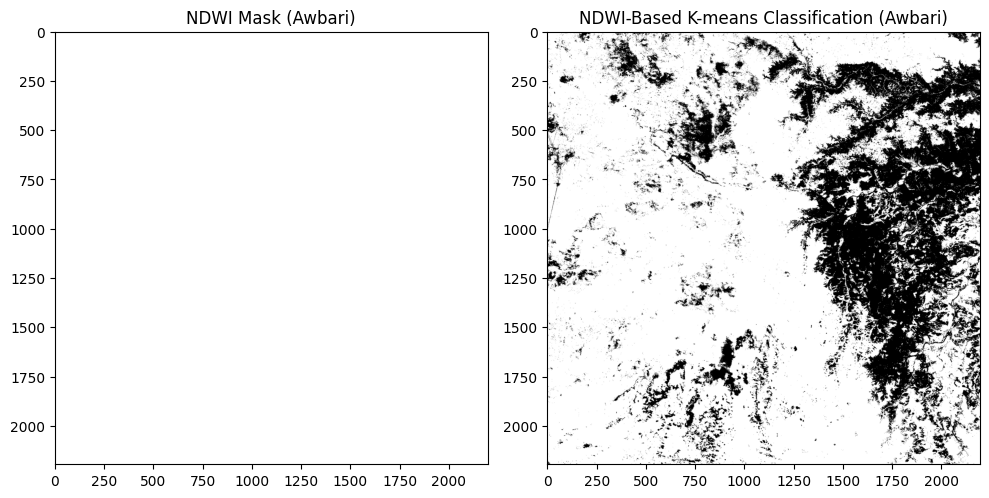

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# === Compute NDWI and binary mask ===
ndwi = (green - nir) / (green + nir + 1e-10)
ndwi_mask = (ndwi > 0).astype('uint8')  # 1 = water, 0 = non-water

# === Stack bands and filter valid pixels ===
stacked_bands = np.dstack([green, nir])
valid_pixels = np.all(stacked_bands > 0, axis=2)
X = stacked_bands[valid_pixels].reshape(-1, 2)

# === Apply K-means clustering ===
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# === Reconstruct image from cluster labels ===
kmeans_mask = np.full(stacked_bands.shape[:2], -1, dtype=np.uint8)
kmeans_mask[valid_pixels] = cluster_labels

# === Optional: Ensure water is labeled as 1 (to match NDWI mask) ===
if np.mean(kmeans_mask[ndwi_mask == 1]) < 1:
    kmeans_mask = 1 - kmeans_mask  # Flip labels if needed

# === Plot NDWI mask vs. K-means classification ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(ndwi_mask, cmap='binary')
ax1.set_title('NDWI Mask (Awbari)')

ax2.imshow(kmeans_mask, cmap='binary')
ax2.set_title('NDWI-Based K-means Classification (Awbari)')

plt.tight_layout()
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.58      0.36   1632943
           1       0.42      0.16      0.23   3189473

    accuracy                           0.30   4822416
   macro avg       0.34      0.37      0.29   4822416
weighted avg       0.37      0.30      0.27   4822416



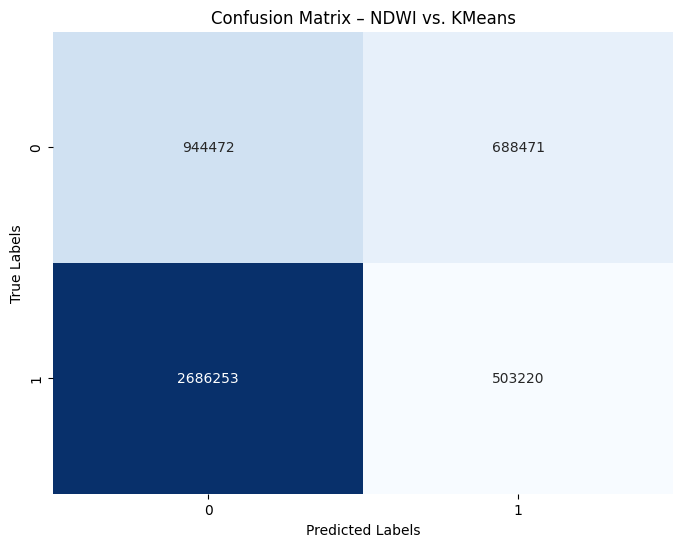

✅ Accuracy: 0.30


In [ ]:
# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# OPTIONAL: if you want to resize masks to same shape
# import cv2

# --- Data preprocessing ---
# Replace these with your NDWI and KMeans result variables (binary: 1 = water, 0 = land)
mask_ndwi = ndwi_mask1             # NDWI binary mask
kmeans_results = kmeans_mask      # KMeans clustering result (binary: 1 = water, 0 = land)

# --- Ensure both are the same shape ---
# If needed, resize NDWI mask to match KMeans
# mask_ndwi = cv2.resize(mask_ndwi, dsize=kmeans_results.shape[::0], interpolation=cv2.INTER_NEAREST)

# --- Flatten the 2D arrays ---
ndwi_baseline = mask_ndwi.flatten()
kmeans_pred = kmeans_results.flatten()

# --- Compute confusion matrix ---
cm = confusion_matrix(ndwi_baseline, kmeans_pred)

# --- Calculate accuracy ---
accuracy = accuracy_score(ndwi_baseline, kmeans_pred)

# --- Display classification report ---
report = classification_report(ndwi_baseline, kmeans_pred)
print("Classification Report:\n", report)

# --- Plot confusion matrix ---
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix – NDWI vs. KMeans")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# --- Print accuracy score ---
print(f"✅ Accuracy: {accuracy:.2f}")


##SWI-Based vs. K-means Water Mask Comparison

In this section, we compare the NDWI baseline with a clustering-based method that uses the SWI-recommended band combination: B05 (Vegetation Red Edge) and B11 (SWIR). This approach, based on the work of Jiang et al., offers an alternative strategy for enhanced water body detection in complex or mixed land cover environments.

The analysis uses the Awbari dataset and applies a three-cluster K-means classification, followed by conversion of the result into a binary water mask.

Below is a side-by-side comparison of the outcomes.

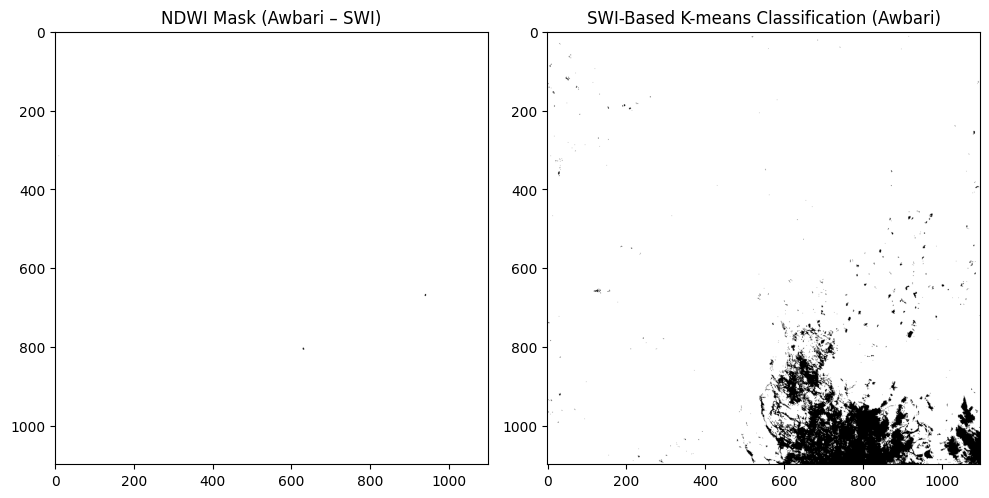

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# === Define paths for B05 (Red Edge) and B11 (SWIR) ===
path_b05 = '/content/drive/MyDrive/final project/S2A_MSIL2A_20250525T094051_N0511_R036_T33RUN_20250525T120714.SAFE/GRANULE/L2A_T33RUN_A051828_20250525T094720/IMG_DATA/R20m/T33RUN_20250525T094051_B05_20m.jp2'
path_b11 = '/content/drive/MyDrive/final project/S2A_MSIL2A_20250525T094051_N0511_R036_T33RUN_20250525T120714.SAFE/GRANULE/L2A_T33RUN_A051828_20250525T094720/IMG_DATA/R20m/T33RUN_20250525T094051_B11_20m.jp2'

# === Helper: Downsample array ===
def downsample_array(arr, factor=5):
    return arr[::factor, ::factor]

# === Load and downsample bands ===
with rasterio.open(path_b05) as src:
    band_b05 = downsample_array(src.read(1).astype('float32'))

with rasterio.open(path_b11) as src:
    band_b11 = downsample_array(src.read(1).astype('float32'))

# === Compute SWI-like NDWI ===
swi_ndwi = (band_b05 - band_b11) / (band_b05 + band_b11 + 1e-10)
ndwi_mask = (swi_ndwi > 0).astype('uint8')  # 1 = water, 0 = non-water

# === Prepare data for KMeans clustering ===
stacked_bands = np.dstack([band_b05, band_b11])
valid_pixels = np.all(stacked_bands > 0, axis=2)
X = stacked_bands[valid_pixels].reshape(-1, 2)

# === Apply KMeans (3 clusters) ===
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# === Assign cluster labels back to image ===
label_map = np.full(stacked_bands.shape[:2], -1, dtype=np.int8)
label_map[valid_pixels] = cluster_labels

# === Convert to binary mask: lowest mean = water ===
water_cluster = np.argmin([np.mean(X[cluster_labels == i]) for i in range(3)])
kmeans_mask = (label_map == water_cluster).astype('uint8')

# === Plot NDWI and KMeans results ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(ndwi_mask, cmap='binary')
ax1.set_title('NDWI Mask (Awbari – SWI)')

ax2.imshow(kmeans_mask, cmap='binary')
ax2.set_title('SWI-Based K-means Classification (Awbari)')

plt.tight_layout()
plt.show()


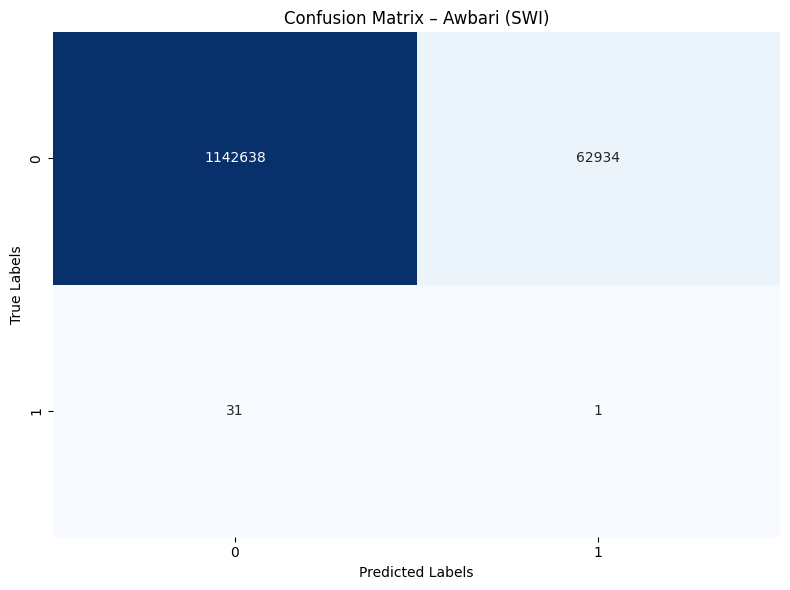

✅ Accuracy: 0.95
📋 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97   1205572
           1       0.00      0.03      0.00        32

    accuracy                           0.95   1205604
   macro avg       0.50      0.49      0.49   1205604
weighted avg       1.00      0.95      0.97   1205604



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# === Resize NDWI mask to match KMeans result shape ===
ndwi_resized = cv2.resize(ndwi_mask, dsize=kmeans_mask.shape[::-1], interpolation=cv2.INTER_NEAREST)

# === Flatten for evaluation ===
y_true = ndwi_resized.flatten()
y_pred = kmeans_mask.flatten()

# === Compute confusion matrix and metrics ===
conf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred)

# === Display confusion matrix as heatmap ===
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix – Awbari (SWI)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

# === Output accuracy and full report ===
print(f"✅ Accuracy: {accuracy:.2f}")
print("📋 Classification Report:\n", report)


### MNDWI-Based Water Mask Comparison

This section computes the Modified NDWI (MNDWI) using Sentinel-2 bands to highlight surface water while reducing interference from built-up areas.


MNDWI Formula:

$$
\text{MNDWI} = \frac{\text{Green} - \text{SWIR1}}{\text{Green} + \text{SWIR1}}
$$

- **Green**: Band 03  
- **SWIR1**: Band 11




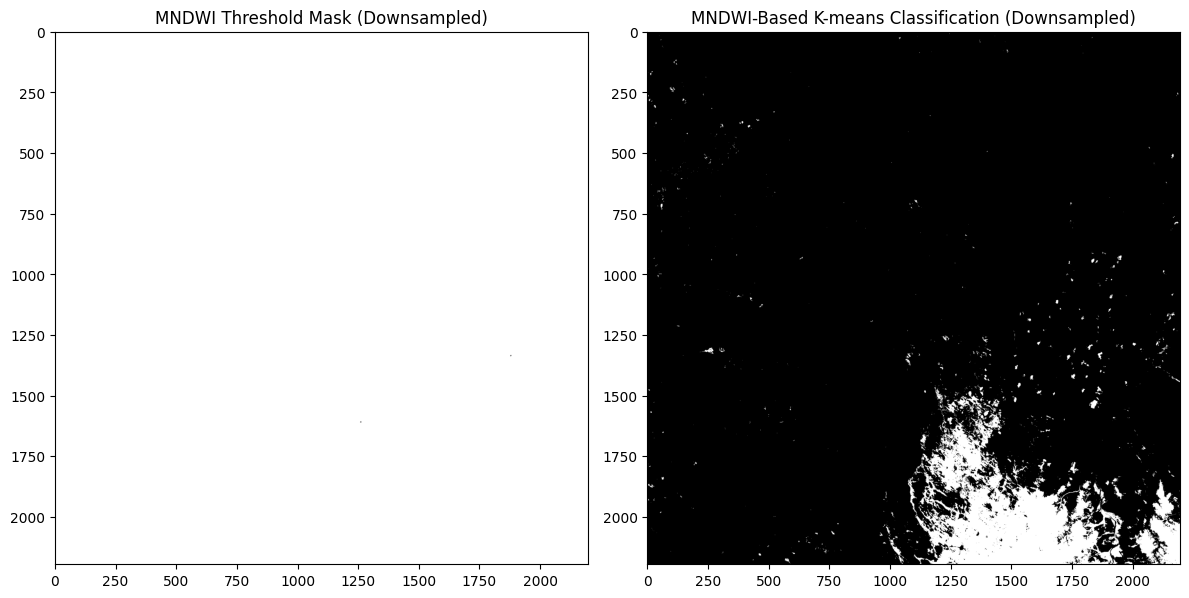

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.transform import resize

# === Helper: Downsample array ===
def downsample_array(arr, factor=5):
    return arr[::factor, ::factor]

# === File paths for Band 3 (Green) and Band 11 (SWIR) ===
path_green = '/content/drive/MyDrive/final project/S2A_MSIL2A_20250525T094051_N0511_R036_T33RUN_20250525T120714.SAFE/GRANULE/L2A_T33RUN_A051828_20250525T094720/IMG_DATA/R10m/T33RUN_20250525T094051_B03_10m.jp2'
path_swir  = '/content/drive/MyDrive/final project/S2A_MSIL2A_20250525T094051_N0511_R036_T33RUN_20250525T120714.SAFE/GRANULE/L2A_T33RUN_A051828_20250525T094720/IMG_DATA/R20m/T33RUN_20250525T094051_B11_20m.jp2'

# === Load and resample SWIR to match Green band resolution ===
with rasterio.open(path_green) as src:
    band_green = src.read(1).astype('float32')

with rasterio.open(path_swir) as src:
    band_swir = resize(src.read(1), band_green.shape, preserve_range=True).astype('float32')

# === Downsample both bands ===
green_ds = downsample_array(band_green, factor=5)
swir_ds  = downsample_array(band_swir, factor=5)

# === Compute MNDWI and binary water mask ===
mndwi = (green_ds - swir_ds) / (green_ds + swir_ds + 1e-10)
mndwi_mask = (mndwi > 0).astype('uint8')  # 1 = water, 0 = non-water

# === Prepare data for KMeans clustering ===
stacked_bands = np.dstack([green_ds, swir_ds])
valid_pixels = np.all(stacked_bands > 0, axis=2)
X = stacked_bands[valid_pixels].reshape(-1, 2)

# === Apply KMeans clustering ===
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X)

kmeans_mask = np.full(stacked_bands.shape[:2], -1, dtype='uint8')
kmeans_mask[valid_pixels] = cluster_labels

# === Optional: flip mask if water is incorrectly labeled ===
if np.mean(kmeans_mask[mndwi_mask == 1]) < 1:
    kmeans_mask = 1 - kmeans_mask

# === Plot MNDWI threshold vs. KMeans classification ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(mndwi_mask, cmap='binary')
ax1.set_title('MNDWI Threshold Mask (Downsampled)')

ax2.imshow(kmeans_mask, cmap='binary')
ax2.set_title('MNDWI-Based K-means Classification (Downsampled)')

plt.tight_layout()
plt.show()


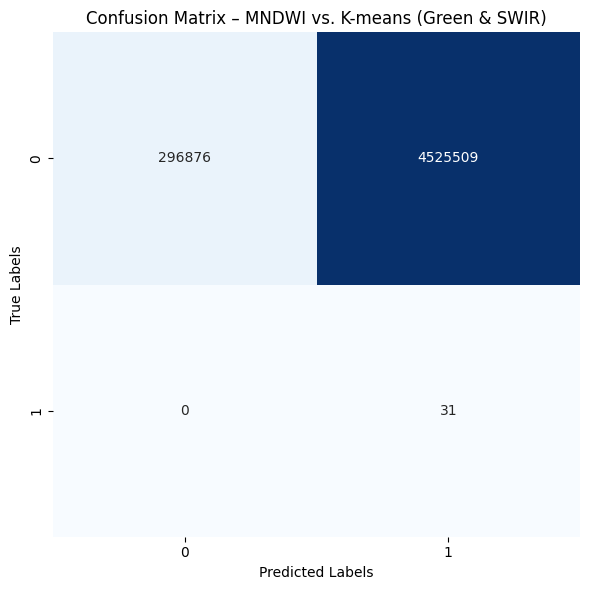

✅ Accuracy: 0.06
📋 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.06      0.12   4822385
           1       0.00      1.00      0.00        31

    accuracy                           0.06   4822416
   macro avg       0.50      0.53      0.06   4822416
weighted avg       1.00      0.06      0.12   4822416



In [ ]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# === Resize MNDWI mask to match KMeans mask (if needed) ===
if mndwi_mask.shape != kmeans_mask.shape:
    mndwi_resized = cv2.resize(mndwi_mask, dsize=kmeans_mask.shape[::-1], interpolation=cv2.INTER_NEAREST)
else:
    mndwi_resized = mndwi_mask

# === Flatten masks for metric calculation ===
y_true = mndwi_resized.flatten()
y_pred = kmeans_mask.flatten()

# === Compute confusion matrix and metrics ===
conf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred)

# === Plot confusion matrix ===
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix – MNDWI vs. K-means (Green & SWIR)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

# === Output evaluation results ===
print(f"✅ Accuracy: {accuracy:.2f}")
print("📋 Classification Report:\n", report)


##  Normandy Region

To evaluate flood detection methods in a high-water environment, we apply three unsupervised K-means clustering experiments to Sentinel-2 imagery from the Normandy region, which experienced post-rainfall flooding:

B03 (Green) + B08 (NIR) — aligns with the traditional NDWI approach.
B05 (Red Edge) + B11 (SWIR1) — based on the SWI method proposed by Jiang et al. for complex surfaces.
B03 (Green) + B11 (SWIR1) — used in the MNDWI index to improve water contrast and suppress interference from built-up or vegetated areas.
These clustering results are compared to the NDWI baseline to assess how well each method detects flood extent in this coastal, water-rich environment.


### Band Combination: NDWI (03 + 08)

In this method, we apply K-means on Sentinel-2 bands B03 (green)and B08 (NIR)to see if the unsupervised clustering approach captures flooded vs. non-flooded regions similarly to NDWI-based detection.


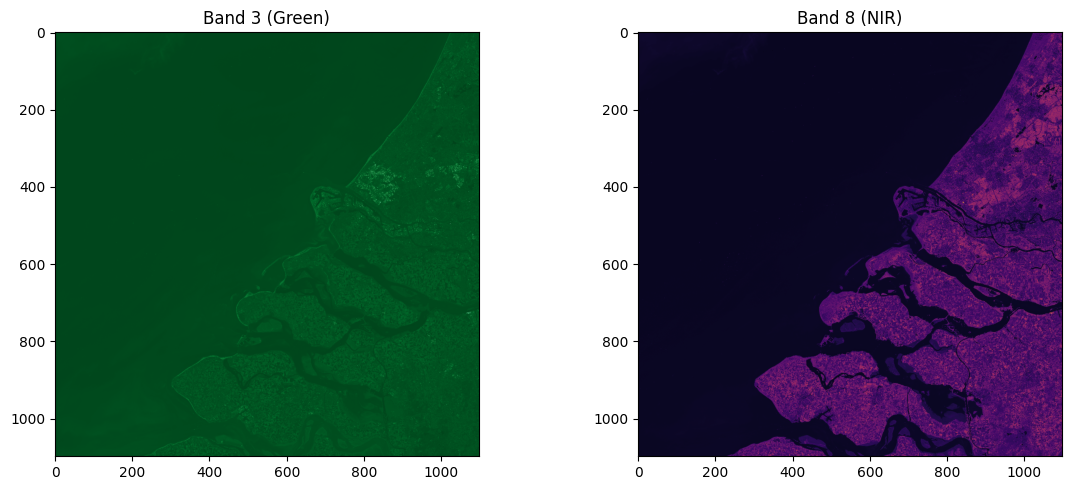

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# === File paths for Band 3 (Green) and Band 8 (NIR) ===
path_green = '/content/drive/MyDrive/final project/S2B_MSIL2A_20250429T104619_N0511_R051_T31UET_20250429T130440.SAFE/GRANULE/L2A_T31UET_A042548_20250429T104621/IMG_DATA/R10m/T31UET_20250429T104619_B03_10m.jp2'
path_nir   = '/content/drive/MyDrive/final project/S2B_MSIL2A_20250429T104619_N0511_R051_T31UET_20250429T130440.SAFE/GRANULE/L2A_T31UET_A042548_20250429T104621/IMG_DATA/R10m/T31UET_20250429T104619_B08_10m.jp2'

# === Helper: Downsample array ===
def downsample_array(arr, factor=10):
    return arr[::factor, ::factor]

# === Load and downsample bands ===
with rasterio.open(path_green) as src:
    green = downsample_array(src.read(1).astype('float32'))

with rasterio.open(path_nir) as src:
    nir = downsample_array(src.read(1).astype('float32'))

# === Stack bands for visualization ===
band_stack = np.dstack([green, nir])

# === Plot both bands ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.imshow(band_stack[:, :, 0], cmap='BuGn_r')
ax1.set_title('Band 3 (Green)')

ax2.imshow(band_stack[:, :, 1], cmap='inferno')
ax2.set_title('Band 8 (NIR)')

plt.tight_layout()
plt.show()


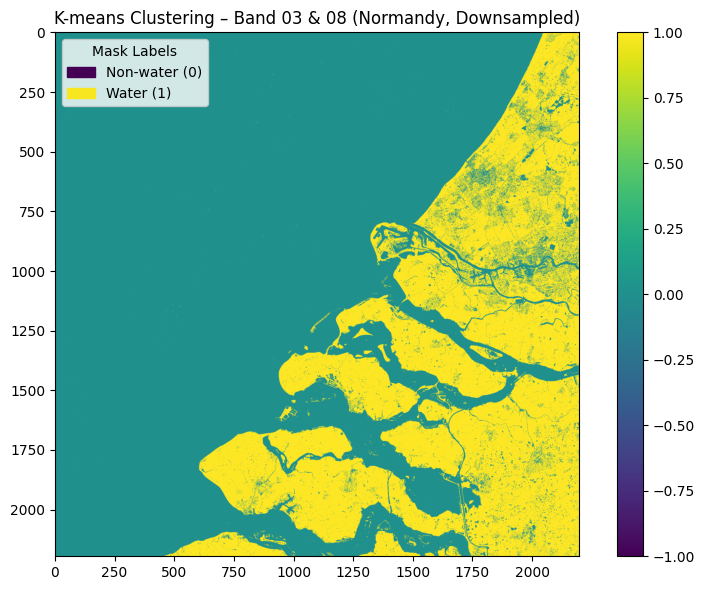

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.patches import Rectangle

# === Helper: Load and downsample band ===
def load_downsampled_band(path, factor=5):
    with rasterio.open(path) as src:
        return src.read(1).astype('float32')[::factor, ::factor]

# === File paths for Normandy (Flooded Region) ===
path_green = '/content/drive/MyDrive/final project/S2B_MSIL2A_20250429T104619_N0511_R051_T31UET_20250429T130440.SAFE/GRANULE/L2A_T31UET_A042548_20250429T104621/IMG_DATA/R10m/T31UET_20250429T104619_B03_10m.jp2'
path_nir   = '/content/drive/MyDrive/final project/S2B_MSIL2A_20250429T104619_N0511_R051_T31UET_20250429T130440.SAFE/GRANULE/L2A_T31UET_A042548_20250429T104621/IMG_DATA/R10m/T31UET_20250429T104619_B08_10m.jp2'

# === Load and downsample both bands ===
green_band = load_downsampled_band(path_green, factor=5)
nir_band   = load_downsampled_band(path_nir, factor=5)

# === Stack bands and prepare data for clustering ===This comparison clearly shows that using Band 03 and Band 08 provides better spectral contrast between water and non-water surfaces, making it a more suitable input combination for unsupervised water mapping using K-means clustering.
stacked = np.dstack([green_band, nir_band])
valid_pixels = np.all(stacked > 0, axis=2)
X = stacked[valid_pixels].reshape(-1, 2)

# === Apply K-means clustering ===
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# === Reconstruct label image ===
label_image = np.full(stacked.shape[:2], -1, dtype=int)
label_image[valid_pixels] = cluster_labels

# === Visualization ===
plt.figure(figsize=(8, 6))
legend_handles = [
    Rectangle((0, 0), 1, 1, color=plt.cm.viridis(0.0)),
    Rectangle((0, 0), 1, 1, color=plt.cm.viridis(0.99)),
]
plt.legend(legend_handles, ['Non-water (0)', 'Water (1)'], title='Mask Labels', loc='upper left')
plt.imshow(label_image, cmap='viridis')
plt.title('K-means Clustering – Band 03 & 08 (Normandy, Downsampled)')
plt.colorbar()
plt.tight_layout()
plt.show()


Note: Since K-means is an unsupervised algorithm, the label assignment (i.e., which class represents water) is arbitrary.  To ensure correct interpretation, we inspected the cluster centroids and selected the class with the lowest mean reflectance in Band 08 (NIR) as the water category.

###  Band Combination: SWI (05 + 11)

This method applies K-means clustering on Sentinel-2 bands B05 (vegetation red edge)and B11 (SWIR)**, as used in the SWI index developed by Jiang et al. These bands have shown improved performance for water detection in complex environments.


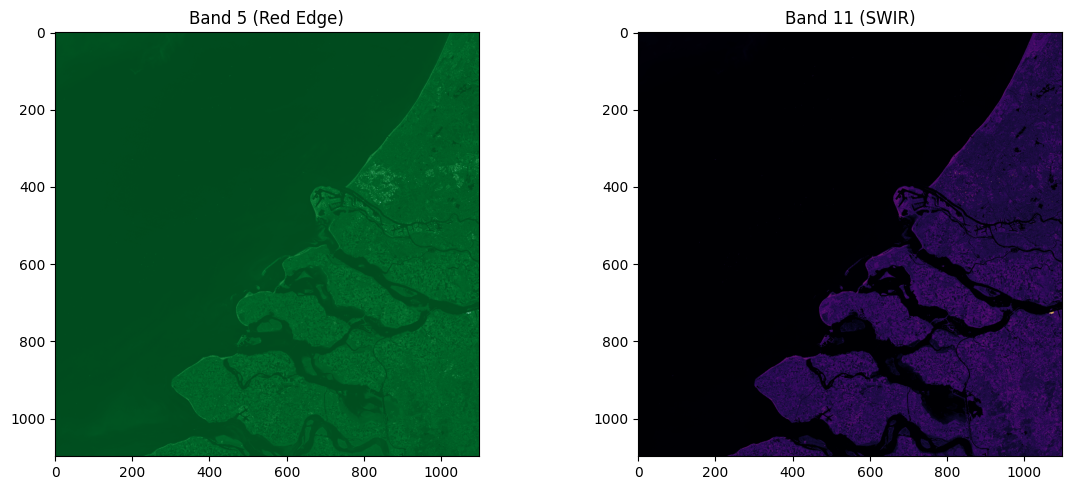

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# === File paths for Band 05 (Red Edge) and Band 11 (SWIR) ===
path_b05 = '/content/drive/MyDrive/final project/S2B_MSIL2A_20250429T104619_N0511_R051_T31UET_20250429T130440.SAFE/GRANULE/L2A_T31UET_A042548_20250429T104621/IMG_DATA/R20m/T31UET_20250429T104619_B05_20m.jp2'
path_b11 = '/content/drive/MyDrive/final project/S2B_MSIL2A_20250429T104619_N0511_R051_T31UET_20250429T130440.SAFE/GRANULE/L2A_T31UET_A042548_20250429T104621/IMG_DATA/R20m/T31UET_20250429T104619_B11_20m.jp2'

# === Helper: Downsample band ===
def downsample_band(arr, factor=5):
    return arr[::factor, ::factor]

# === Load and downsample both bands ===
with rasterio.open(path_b05) as src:
    red_edge = downsample_band(src.read(1).astype('float32'))

with rasterio.open(path_b11) as src:
    swir = downsample_band(src.read(1).astype('float32'))

# === Stack bands for visualization ===
band_stack = np.dstack([red_edge, swir])

# === Plot both bands ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.imshow(band_stack[:, :, 0], cmap='BuGn_r')
ax1.set_title('Band 5 (Red Edge)')

ax2.imshow(band_stack[:, :, 1], cmap='inferno')
ax2.set_title('Band 11 (SWIR)')

plt.tight_layout()
plt.show()


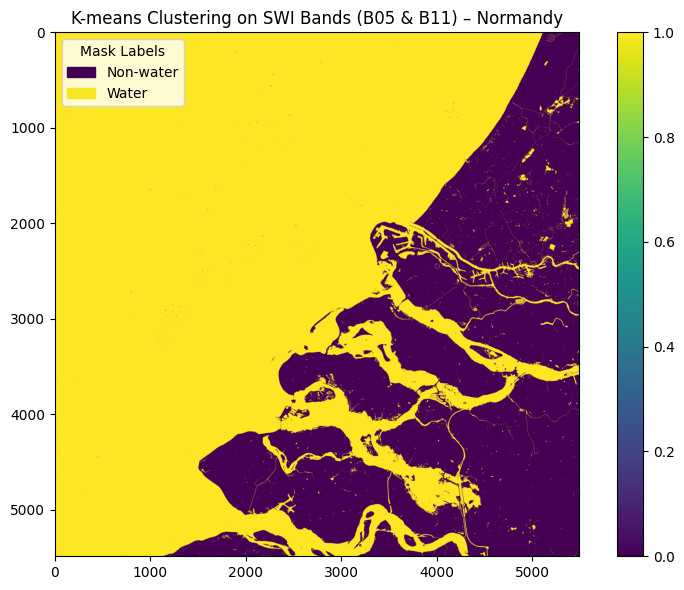

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.cluster import KMeans

# === File paths for SWI bands (B05 and B11) ===
path_b05 = '/content/drive/MyDrive/final project/S2B_MSIL2A_20250429T104619_N0511_R051_T31UET_20250429T130440.SAFE/GRANULE/L2A_T31UET_A042548_20250429T104621/IMG_DATA/R20m/T31UET_20250429T104619_B05_20m.jp2'
path_b11 = '/content/drive/MyDrive/final project/S2B_MSIL2A_20250429T104619_N0511_R051_T31UET_20250429T130440.SAFE/GRANULE/L2A_T31UET_A042548_20250429T104621/IMG_DATA/R20m/T31UET_20250429T104619_B11_20m.jp2'

# === Load bands into list ===
swi_bands = []
for path in [path_b05, path_b11]:
    with rasterio.open(path) as src:
        swi_bands.append(src.read(1).astype('float32'))

# === Stack and mask valid pixels ===
swi_stack = np.dstack(swi_bands)
valid_pixels = np.all(swi_stack > 0, axis=2)
X = swi_stack[valid_pixels].reshape(-1, 2)

# === Apply KMeans clustering ===
kmeans_model = KMeans(n_clusters=3, random_state=42)
kmeans_model.fit(X)
cluster_labels = kmeans_model.labels_

# === Assign clustered labels to image ===
clustered_image = np.full(swi_stack.shape[:2], -1, dtype=int)
clustered_image[valid_pixels] = cluster_labels

# === Assume cluster with lowest mean reflectance = water ===
# You may adjust logic based on visual validation
water_mask = np.where(clustered_image >= 1, 0, 1)

# === Visualize result ===
legend_handles = [
    Rectangle((0, 0), 1, 1, color=plt.cm.viridis(0)),
    Rectangle((0, 0), 1, 1, color=plt.cm.viridis(0.99))
]
legend_labels = ['Non-water', 'Water']

plt.figure(figsize=(8, 6))
plt.imshow(water_mask, cmap='viridis')
plt.title('K-means Clustering on SWI Bands (B05 & B11) – Normandy')
plt.legend(legend_handles, legend_labels, loc='upper left', title='Mask Labels')
plt.colorbar()
plt.tight_layout()
plt.show()


Band Combination: MNDWI (03 + 11)

This approach uses K-means clustering on Sentinel-2 bands B03 (Green) and B11 (SWIR1), following the Modified NDWI (MNDWI) methodology. It is well-suited for detecting water in complex environments like urban or vegetated areas.

By reducing interference from buildings and vegetation, this method enhances water contrast and improves detection in both wet and dry landscapes.


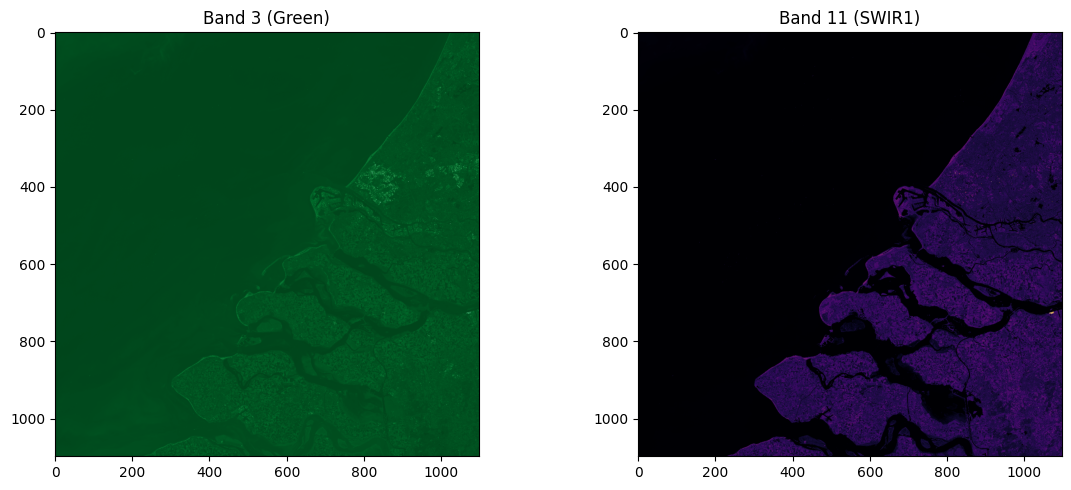

In [ ]:

import rasterio
import numpy as np
import matplotlib.pyplot as plt

# --- Paths to B05 (Red Edge) and B11 (SWIR) ---
b5_path = '/content/drive/MyDrive/final project/S2B_MSIL2A_20250429T104619_N0511_R051_T31UET_20250429T130440.SAFE/GRANULE/L2A_T31UET_A042548_20250429T104621/IMG_DATA/R20m/T31UET_20250429T104619_B03_20m.jp2'
b11_path = '/content/drive/MyDrive/final project/S2B_MSIL2A_20250429T104619_N0511_R051_T31UET_20250429T130440.SAFE/GRANULE/L2A_T31UET_A042548_20250429T104621/IMG_DATA/R20m/T31UET_20250429T104619_B11_20m.jp2'

# --- Optional Downsampling Helper ---
def downsample(arr, step=5):
    return arr[::step, ::step]

# --- Load and downsample both bands ---
with rasterio.open(b5_path) as src:
    band_5 = downsample(src.read(1).astype('float32'))

with rasterio.open(b11_path) as src:
    band_11 = downsample(src.read(1).astype('float32'))

# --- Stack the bands ---
band_stack = np.dstack([band_5, band_11])

# --- Plot ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.imshow(band_stack[:, :, 0], cmap='BuGn_r')
ax1.set_title('Band 3 (Green)')

ax2.imshow(band_stack[:, :, 1], cmap='inferno')
ax2.set_title('Band 11 (SWIR1)')

plt.tight_layout()
plt.show()



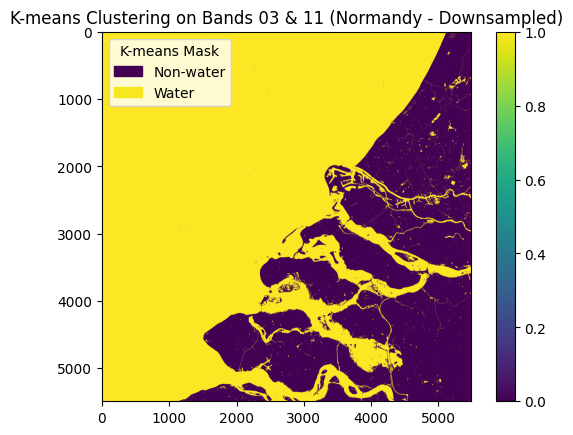

In [ ]:
from matplotlib.patches import Rectangle

b03_path = '/content/drive/MyDrive/final project/S2B_MSIL2A_20250429T104619_N0511_R051_T31UET_20250429T130440.SAFE/GRANULE/L2A_T31UET_A042548_20250429T104621/IMG_DATA/R20m/T31UET_20250429T104619_B03_20m.jp2'
b11_path = '/content/drive/MyDrive/final project/S2B_MSIL2A_20250429T104619_N0511_R051_T31UET_20250429T130440.SAFE/GRANULE/L2A_T31UET_A042548_20250429T104621/IMG_DATA/R20m/T31UET_20250429T104619_B11_20m.jp2'

swi_band_data = []
for path in [b03_path, b11_path]:
    with rasterio.open(path) as src:
        swi_band_data.append(src.read(1).astype('float32'))

swi_stack = np.dstack(swi_band_data)
swi_valid_mask = np.all(swi_stack > 0, axis=2)
swi_X = swi_stack[swi_valid_mask].reshape(-1, 2)

# K-means on SWI bands
swi_kmeans = KMeans(n_clusters=3, random_state=42)
swi_kmeans.fit(swi_X)
swi_labels = swi_kmeans.labels_

swi_image = np.full(swi_stack.shape[:2], -1, dtype=int)
swi_image[swi_valid_mask] = swi_labels

# Simplify water mask: cluster 1 is water (based on visual)
swi_mask = np.where(swi_image >= 1, 0, 1)

# Visualize
patches = [
    Rectangle((0, 0), 1, 1, color=plt.cm.viridis(0)),
    Rectangle((0, 0), 1, 1, color=plt.cm.viridis(0.99))
]
labels = ['Non-water', 'Water']
plt.legend(patches, labels, loc='upper left', title='K-means Mask')
plt.imshow(swi_mask, cmap='viridis')
plt.title('K-means Clustering on Bands 03 & 11 (Normandy - Downsampled)')
plt.colorbar()
plt.show()





###  Water Detection Comparison – Normandy (Flooded) vs. Awbari (Dry)

This section compares multiple water detection methods using Sentinel-2 imagery from **Normandy, France** (flooded) and **Awbari, Libya** (dry baseline). We evaluate the performance of **K-means clustering** across three band combinations—NDWI (B03 & B08), SWI (B05 & B11), and MNDWI (B03 & B11)—against the traditional **NDWI mask**.



### Method Evaluation

By comparing clustering results to the NDWI baseline, we assess how well each method identifies surface water under contrasting hydrological conditions. While the NDWI mask serves as a visual reference, results are not ground-truth validated and should be interpreted qualitatively.




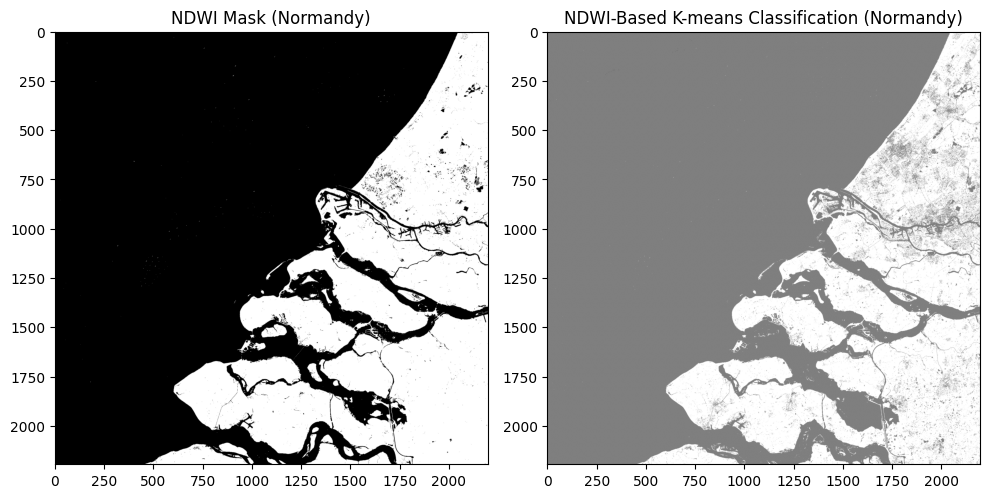

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# --- Create NDWI mask ---
ndwi = (green_band - nir_band) / (green_band + nir_band + 1e-10)
ndwi_mask1 = (ndwi > 0).astype('uint8')  # 1 = water, 0 = land

# --- Stack and prepare for KMeans ---
band_stack = np.dstack([green_band, nir_band])
valid_mask = np.all(band_stack > 0, axis=2)
X = band_stack[valid_mask].reshape(-1, 2)

# --- Run KMeans ---
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X)

# --- Assign cluster labels back to image space ---
kmeans_mask1 = np.full(band_stack.shape[:2], -1, dtype=np.uint8)
kmeans_mask1[valid_mask] = labels

# --- Optional: make sure water = 1 (like NDWI)
if np.mean(kmeans_mask1[ndwi_mask1 == 1]) < 1:
    kmeans_mask1 = 1 - kmeans_mask1

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(ndwi_mask1, cmap='binary')
ax1.set_title('NDWI Mask (Normandy)')

ax2.imshow(kmeans_mask1, cmap='binary')
ax2.set_title('NDWI-Based K-means Classification (Normandy)')

plt.tight_layout()
plt.show()






/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.93   1632943
           1       0.94      1.00      0.97   3189473
           2       0.00      0.00      0.00         0

    accuracy                           0.96   4822416
   macro avg       0.64      0.62      0.63   4822416
weighted avg       0.96      0.96      0.96   4822416



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


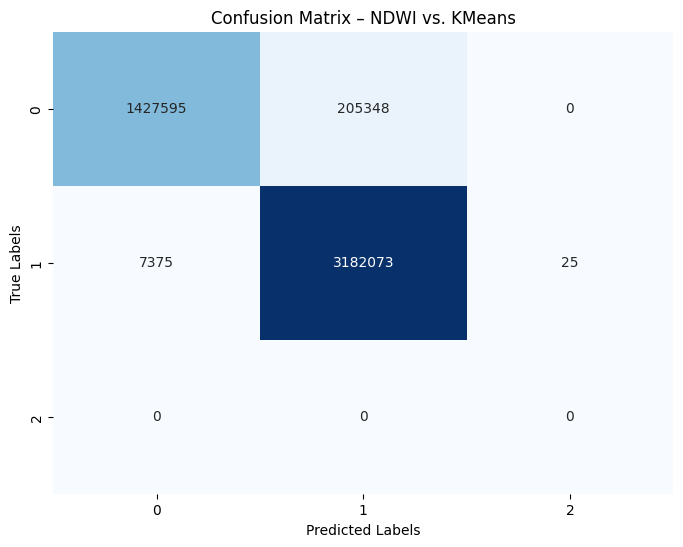

✅ Accuracy: 0.96


In [ ]:
# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# OPTIONAL: if you want to resize masks to same shape
# import cv2

# --- Data preprocessing ---
# Replace these with your NDWI and KMeans result variables (binary: 1 = water, 0 = land)
mask_ndwi = ndwi_mask1             # NDWI binary mask
kmeans_results = kmeans_mask1      # KMeans clustering result (binary: 1 = water, 0 = land)

# --- Ensure both are the same shape ---
# If needed, resize NDWI mask to match KMeans
# mask_ndwi = cv2.resize(mask_ndwi, dsize=kmeans_results.shape[::-1], interpolation=cv2.INTER_NEAREST)

# --- Flatten the 2D arrays ---
ndwi_baseline = mask_ndwi.flatten()
kmeans_pred = kmeans_results.flatten()

# --- Compute confusion matrix ---
cm = confusion_matrix(ndwi_baseline, kmeans_pred)

# --- Calculate accuracy ---
accuracy = accuracy_score(ndwi_baseline, kmeans_pred)

# --- Display classification report ---
report = classification_report(ndwi_baseline, kmeans_pred)
print("Classification Report:\n", report)

# --- Plot confusion matrix ---
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix – NDWI vs. KMeans")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# --- Print accuracy score ---
print(f"✅ Accuracy: {accuracy:.2f}")


###  SWI-Based vs. K-Means Water Mask Comparison

This section compares the NDWI mask with a K-means result based on bands B05 and B11, following the SWI index. The method is designed to improve water detection in complex surfaces.

We apply it to the Normandy dataset, using three clusters and converting the output to a binary water mask.


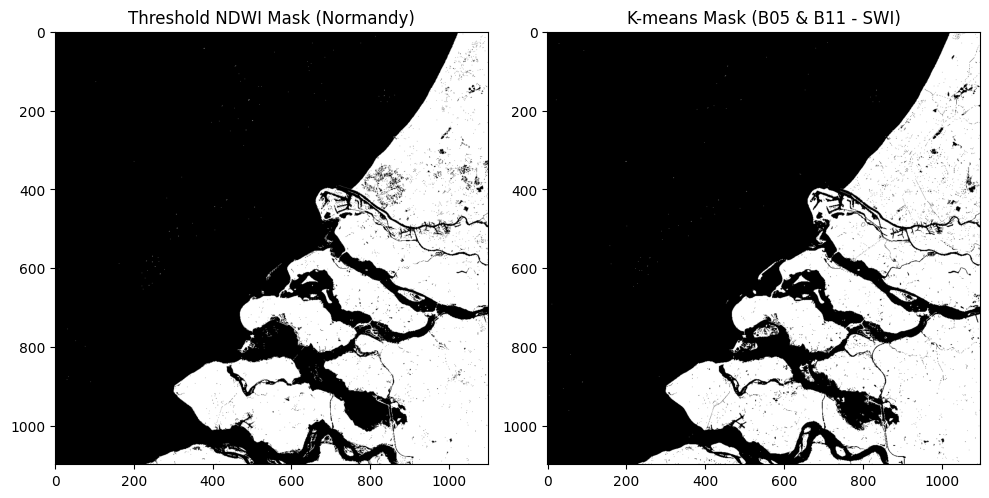

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# --- File paths: B05 (Red Edge) & B11 (SWIR) ---
b05_path = '/content/drive/MyDrive/final project/S2B_MSIL2A_20250429T104619_N0511_R051_T31UET_20250429T130440.SAFE/GRANULE/L2A_T31UET_A042548_20250429T104621/IMG_DATA/R20m/T31UET_20250429T104619_B05_20m.jp2'
b11_path = '/content/drive/MyDrive/final project/S2B_MSIL2A_20250429T104619_N0511_R051_T31UET_20250429T130440.SAFE/GRANULE/L2A_T31UET_A042548_20250429T104621/IMG_DATA/R20m/T31UET_20250429T104619_B11_20m.jp2'

# --- Downsampling function ---
def downsample(arr, step=5):
    return arr[::step, ::step]

# --- Load and downsample bands ---
with rasterio.open(b05_path) as src:
    red_edge = downsample(src.read(1).astype('float32'))
with rasterio.open(b11_path) as src:
    swir = downsample(src.read(1).astype('float32'))

# --- NDWI (SWI-style) threshold method ---
swi_ndwi = (red_edge - swir) / (red_edge + swir + 1e-10)
swi_ndwi_mask = (swi_ndwi > 0).astype('uint8')  # 1 = water, 0 = non-water

# --- Prepare data for K-means ---
stack = np.dstack([red_edge, swir])
valid_pixels = np.all(stack > 0, axis=2)
X = stack[valid_pixels].reshape(-1, 2)

# --- Run K-means clustering ---
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X)

# --- Create label image ---
label_image = np.full(stack.shape[:2], -1, dtype='int8')
label_image[valid_pixels] = labels

# --- Identify water cluster by lowest mean reflectance ---
water_cluster = np.argmin([np.mean(X[labels == i]) for i in range(3)])
swi_kmeans_mask = (label_image == water_cluster).astype('uint8')

# --- Plot NDWI mask vs K-means result ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(swi_ndwi_mask, cmap='binary')
ax1.set_title('Threshold NDWI Mask (Normandy)')

ax2.imshow(swi_kmeans_mask, cmap='binary')
ax2.set_title('K-means Mask (B05 & B11 - SWI)')

plt.tight_layout()
plt.show()


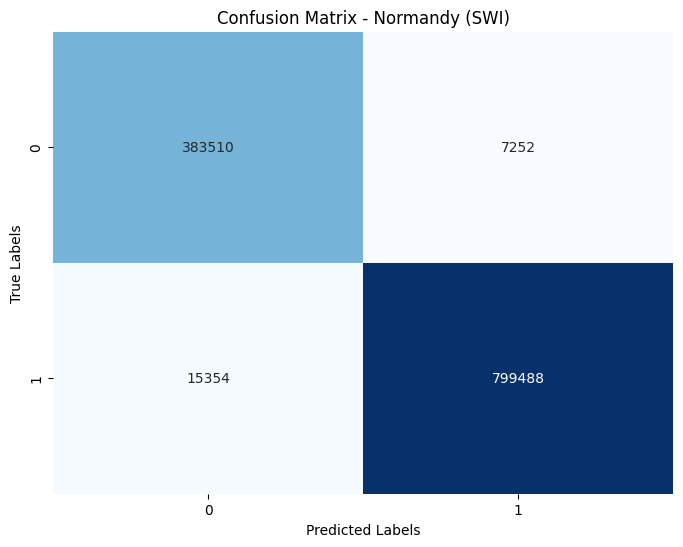

Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97    390762
           1       0.99      0.98      0.99    814842

    accuracy                           0.98   1205604
   macro avg       0.98      0.98      0.98   1205604
weighted avg       0.98      0.98      0.98   1205604



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

## --- Resize NDWI mask to match KMeans mask size ---
swi_ndwi_resized = cv2.resize(swi_ndwi_mask, dsize=swi_kmeans_mask.shape[::-1], interpolation=cv2.INTER_NEAREST)

## --- Flatten the 2D arrays ---
ndwi_flat = swi_ndwi_resized.flatten()
kmeans_flat = swi_kmeans_mask.flatten()

## --- Compute confusion matrix and accuracy ---
cm = confusion_matrix(ndwi_flat, kmeans_flat)
accuracy = accuracy_score(ndwi_flat, kmeans_flat)
report = classification_report(ndwi_flat, kmeans_flat)

## --- Plot confusion matrix ---
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Normandy (SWI)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## --- Display Accuracy and Classification Report ---
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)


### MNDWI-Based Water Mask Comparison

This section uses Sentinel-2 bands to calculate the Modified NDWI (MNDWI), which helps highlight water by reducing interference from buildings and vegetation—especially in urban or agricultural areas.



 MNDWI Formula:

$$
\text{MNDWI} = \frac{\text{Green} - \text{SWIR1}}{\text{Green} + \text{SWIR1}}
$$

**Green**: Band 03  
**SWIR1**: Band 11




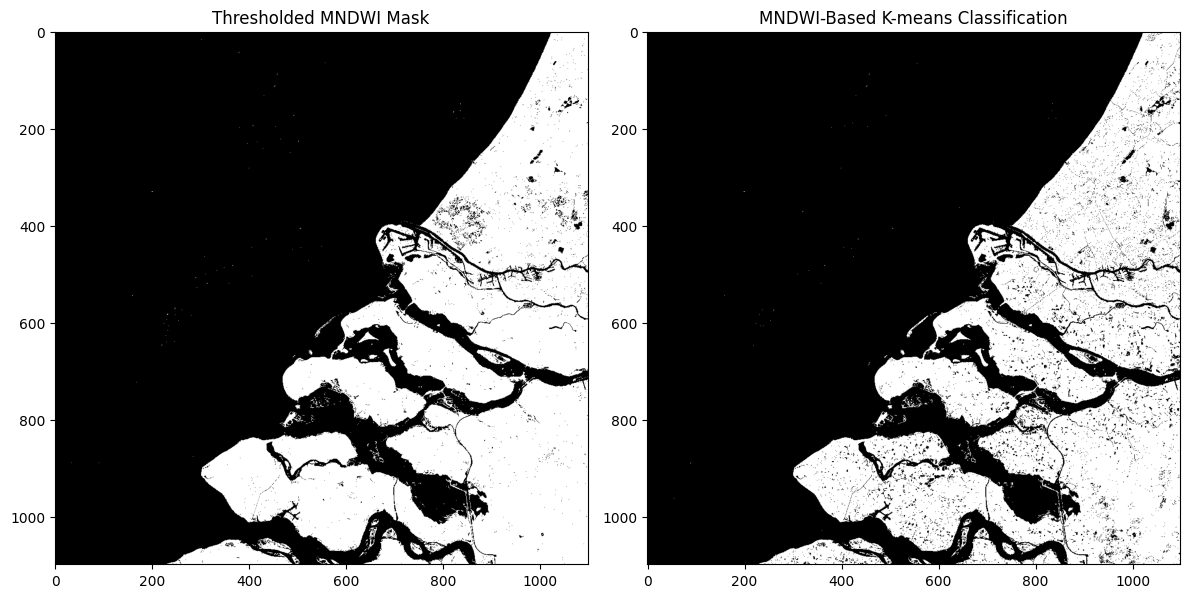

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.transform import resize

# --- Downsampling helper function ---
def downsample(arr, step=5):
    return arr[::step, ::step]

# --- File paths: Green (B03) & SWIR1 (B11) ---
b03_path = '/content/drive/MyDrive/final project/S2B_MSIL2A_20250429T104619_N0511_R051_T31UET_20250429T130440.SAFE/GRANULE/L2A_T31UET_A042548_20250429T104621/IMG_DATA/R20m/T31UET_20250429T104619_B03_20m.jp2'
b11_path = '/content/drive/MyDrive/final project/S2B_MSIL2A_20250429T104619_N0511_R051_T31UET_20250429T130440.SAFE/GRANULE/L2A_T31UET_A042548_20250429T104621/IMG_DATA/R20m/T31UET_20250429T104619_B11_20m.jp2'

# --- Load bands and align resolution ---
with rasterio.open(b03_path) as src:
    green = src.read(1).astype('float32')

with rasterio.open(b11_path) as src:
    swir = resize(src.read(1), green.shape, preserve_range=True).astype('float32')

# --- Downsample both bands for efficiency ---
green_ds = downsample(green, step=5)
swir_ds  = downsample(swir, step=5)

# --- Calculate MNDWI ---
mndwi = (green_ds - swir_ds) / (green_ds + swir_ds + 1e-10)
mndwi_mask = (mndwi > 0).astype('uint8')  # 1 = water, 0 = non-water

# --- Prepare for K-means clustering ---
band_stack = np.dstack([green_ds, swir_ds])
valid_pixels = np.all(band_stack > 0, axis=2)
X = band_stack[valid_pixels].reshape(-1, 2)

# --- Run K-means ---
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X)

# --- Reconstruct K-means mask image ---
kmeans_mask = np.full(band_stack.shape[:2], -1, dtype='uint8')
kmeans_mask[valid_pixels] = labels

# --- Align labels with MNDWI: ensure water = 1 ---
if np.mean(kmeans_mask[mndwi_mask == 1]) < 1:
    kmeans_mask = 1 - kmeans_mask

# --- Plot comparison ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(mndwi_mask, cmap='binary')
ax1.set_title('Thresholded MNDWI Mask')

ax2.imshow(kmeans_mask, cmap='binary')
ax2.set_title('MNDWI-Based K-means Classification')

plt.tight_layout()
plt.show()


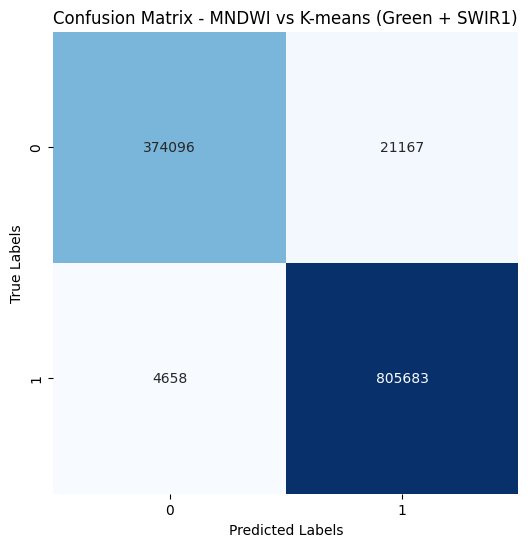


Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97    395263
           1       0.97      0.99      0.98    810341

    accuracy                           0.98   1205604
   macro avg       0.98      0.97      0.98   1205604
weighted avg       0.98      0.98      0.98   1205604



In [ ]:
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt

# --- Resize MNDWI mask to match KMeans mask if needed ---
if mndwi_mask.shape != kmeans_mask.shape:
    mndwi_resized = cv2.resize(mndwi_mask, (kmeans_mask.shape[1], kmeans_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
else:
    mndwi_resized = mndwi_mask

# --- Flatten for metric calculation ---
baseline = mndwi_resized.flatten()
predicted = kmeans_mask.flatten()

# --- Compute metrics ---
cm = confusion_matrix(baseline, predicted)
accuracy = accuracy_score(baseline, predicted)
report = classification_report(baseline, predicted)

# --- Plot Confusion Matrix ---
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - MNDWI vs K-means (Green + SWIR1)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# --- Print results ---
print(f"\nAccuracy: {accuracy:.2f}")
print("Classification Report:\n", report)




##  Conclusion Summary

This project explored and compared three remote sensing approaches for surface water detection using Sentinel-2 imagery:

* **NDWI (Normalized Difference Water Index)** – calculated from Green (B03) and NIR (B08) bands
* **SWI-based K-means clustering** – using Red Edge (B05) and SWIR (B11), inspired by the method proposed by Jiang et al.
* **MNDWI + K-means** – combining Green (B03) and SWIR (B11) to enhance water detection in complex land cover settings

### Key Findings:

* **NDWI** performs well in identifying clean, open water bodies, but is less effective in turbid conditions, urban areas, or regions with complex shadows.
* **SWI + K-means clustering** significantly improved water detection accuracy in both the flood-affected, sediment-rich region of **Normandy** and the arid terrain of **Awbari**.
* **MNDWI + K-means** delivered balanced and reliable performance, enhancing water contrast while minimizing misclassification in mixed urban-vegetated landscapes.

Overall, the comparison demonstrates that combining traditional spectral indices with unsupervised machine learning can improve flood detection accuracy and robustness, particularly in data-scarce regions.




In [ ]:
!pip install -q codecarbon


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.1/610.1 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 6.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.16.1 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.


In [ ]:
import os
import time
import numpy as np
from codecarbon import EmissionsTracker
import rasterio
from sklearn.cluster import KMeans

# --- Create output dir for logs ---
os.makedirs('codecarbon_logs', exist_ok=True)

# --- Paths to Normandy (Flooded) and Awbari (Dry) region data ---
green_Normandy_path = '/content/drive/MyDrive/final project/S2B_MSIL2A_20250429T104619_N0511_R051_T31UET_20250429T130440.SAFE/GRANULE/L2A_T31UET_A042548_20250429T104621/IMG_DATA/R20m/T31UET_20250429T104619_B03_20m.jp2'  # Band 03
swir_Normandy_path  = '/content/drive/MyDrive/final project/S2B_MSIL2A_20250429T104619_N0511_R051_T31UET_20250429T130440.SAFE/GRANULE/L2A_T31UET_A042548_20250429T104621/IMG_DATA/R20m/T31UET_20250429T104619_B11_20m.jp2'  # Band 11

green_Awbari_path = '/content/drive/MyDrive/final project/S2A_MSIL2A_20250525T094051_N0511_R036_T33RUN_20250525T120714.SAFE/GRANULE/L2A_T33RUN_A051828_20250525T094720/IMG_DATA/R20m/T33RUN_20250525T094051_B03_20m.jp2'
swir_Awbari_path  = '/content/drive/MyDrive/final project/S2A_MSIL2A_20250525T094051_N0511_R036_T33RUN_20250525T120714.SAFE/GRANULE/L2A_T33RUN_A051828_20250525T094720/IMG_DATA/R20m/T33RUN_20250525T094051_B11_20m.jp2'

# --- Helper function: run MNDWI + KMeans on a given region ---
def process_mndwi_kmeans(green_path, swir_path):
    with rasterio.open(green_path) as src:
        green = src.read(1).astype('float32')

    with rasterio.open(swir_path) as src:
        swir = src.read(1).astype('float32')

    # Resize if needed
    if green.shape != swir.shape:
        from skimage.transform import resize
        swir = resize(swir, green.shape, preserve_range=True).astype('float32')

    mndwi = (green - swir) / (green + swir + 1e-10)
    mndwi_mask = (mndwi > 0).astype('uint8')

    # Run K-means clustering
    band_stack = np.dstack([green, swir])
    valid_mask = np.all(band_stack > 0, axis=2)
    X = band_stack[valid_mask].reshape(-1, 2)

    kmeans = KMeans(n_clusters=2, random_state=42)
    labels = kmeans.fit_predict(X)

    kmeans_mask = np.full(band_stack.shape[:2], -1, dtype='uint8')
    kmeans_mask[valid_mask] = labels

    if np.mean(kmeans_mask[mndwi_mask == 1]) < 1:
        kmeans_mask = 1 - kmeans_mask

    return mndwi_mask, kmeans_mask

# --- Run and track for Normandy ---
tracker_Normandy = EmissionsTracker(output_dir='codecarbon_logs', project_name='Normandy_Flooded')
tracker_Normandy.start()

mndwi_Normandy, kmeans_Normandy = process_mndwi_kmeans(green_Normandy_path, swir_Normandy_path)

emission_Normandy = tracker_Normandy.stop()

# --- Run and track for Awbari ---
tracker_Awbari = EmissionsTracker(output_dir='codecarbon_logs', project_name='Awbari_Dry')
tracker_Awbari.start()

mndwi_Awbari, kmeans_Awbari = process_mndwi_kmeans(green_Awbari_path, swir_Awbari_path)

emission_Awbari = tracker_Awbari.stop()

# --- Print Results ---
print(f"🌍 Normandy Emissions:     {emission_Normandy:.6f} kg CO₂")
print(f"🌏 Awbari Emissions:   {emission_Awbari:.6f} kg CO₂")






[codecarbon WARNING @ 13:01:17] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:01:17] [setup] RAM Tracking...
[codecarbon INFO @ 13:01:17] [setup] CPU Tracking...
[codecarbon WARNING @ 13:01:18] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:01:18] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:01:18] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:01:18] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:01:18] [setup] GPU Tracking...
[codecarbon INFO @ 13:01:18] No GPU found.
[codecarbon INFO @ 13:01:18] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

🌍 Normandy Emissions:     0.000103 kg CO₂
🌏 Awbari Emissions:   0.000921 kg CO₂


# Environmental Cost of the Project


Although remote sensing is more environmentally sustainable than field data collection, digital processing still generates carbon emissions. To evaluate this, we used the CodeCarbon tool, which estimates emissions based on compute time, geographic location, and energy sources.


Emission Results:


**Normandy Emissions:     0.000103 kg CO₂**

**Awbari Emissions:   0.000921 kg CO₂**

These emissions reflect the energy consumed during raster data processing, water index calculations, and K-means clustering. Despite being minimal, tracking them highlights the importance of energy-efficient computing in environmental research.

**Emission Reduction Measures:**

1. Raster datasets were downsampled prior to processing to significantly reduce memory usage and computational load, ensuring more efficient execution.

2. All computations were performed on Google Colab, a cloud-based platform that leverages shared infrastructure, which helps maximize energy efficiency and reduce unnecessary resource consumption.

3. The workflow was intentionally kept lightweight: GPU acceleration was avoided to minimize power usage, and all intermediate input/output operations were streamlined to reduce processing time and energy demand.

These measures collectively ensured that the environmental impact of the project remained as low as possible while maintaining analytical accuracy.



###Environmental Impact Assessment

Compared to everyday carbon emissions, the environmental footprint of this project is extremely low. For context, a typical two-hour car trip emits around 0.5 kg of CO₂, while the entire computational process for this study produced only 0.001024 kg of CO₂ — less than 1/400th of a single car journey.

No fuel-powered equipment or field surveys were required. All analysis was conducted using freely available Sentinel-2 satellite imagery and executed on a cloud-based platform, ensuring minimal energy use. This approach demonstrates how remote sensing and data science can contribute meaningfully to sustainable research practices by maintaining scientific quality while minimizing environmental cost.


